This notebook contains code to help explore the dataset. 

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from data_loader import scores_df

null performances after coercion: 0
after saturation filter 2452
after filter num benchmarks 2021
after merge with model versions 2017
after merge with benchmark dates 2017
Original number of rows: 2017
Number of rows after aggregation: 1405


In [3]:
len(scores_df["model"].unique())

185

In [4]:
len(scores_df["benchmark"].unique())



41

In [3]:
scores_df[["benchmark_id", "benchmark"]].drop_duplicates()

,benchmark_id,benchmark
0,b1,GPQA diamond
1,b11,Balrog
2,b17,DeepResearch Bench
3,b19,GeoBench
4,b2,FrontierMath-2025-02-28-Private
5,b26,SimpleBench
6,b31,WeirdML
7,b4,OTIS Mock AIME 2024-2025
8,b5,FrontierMath-Tier-4-2025-07-01-Private
9,b7,Aider polyglot


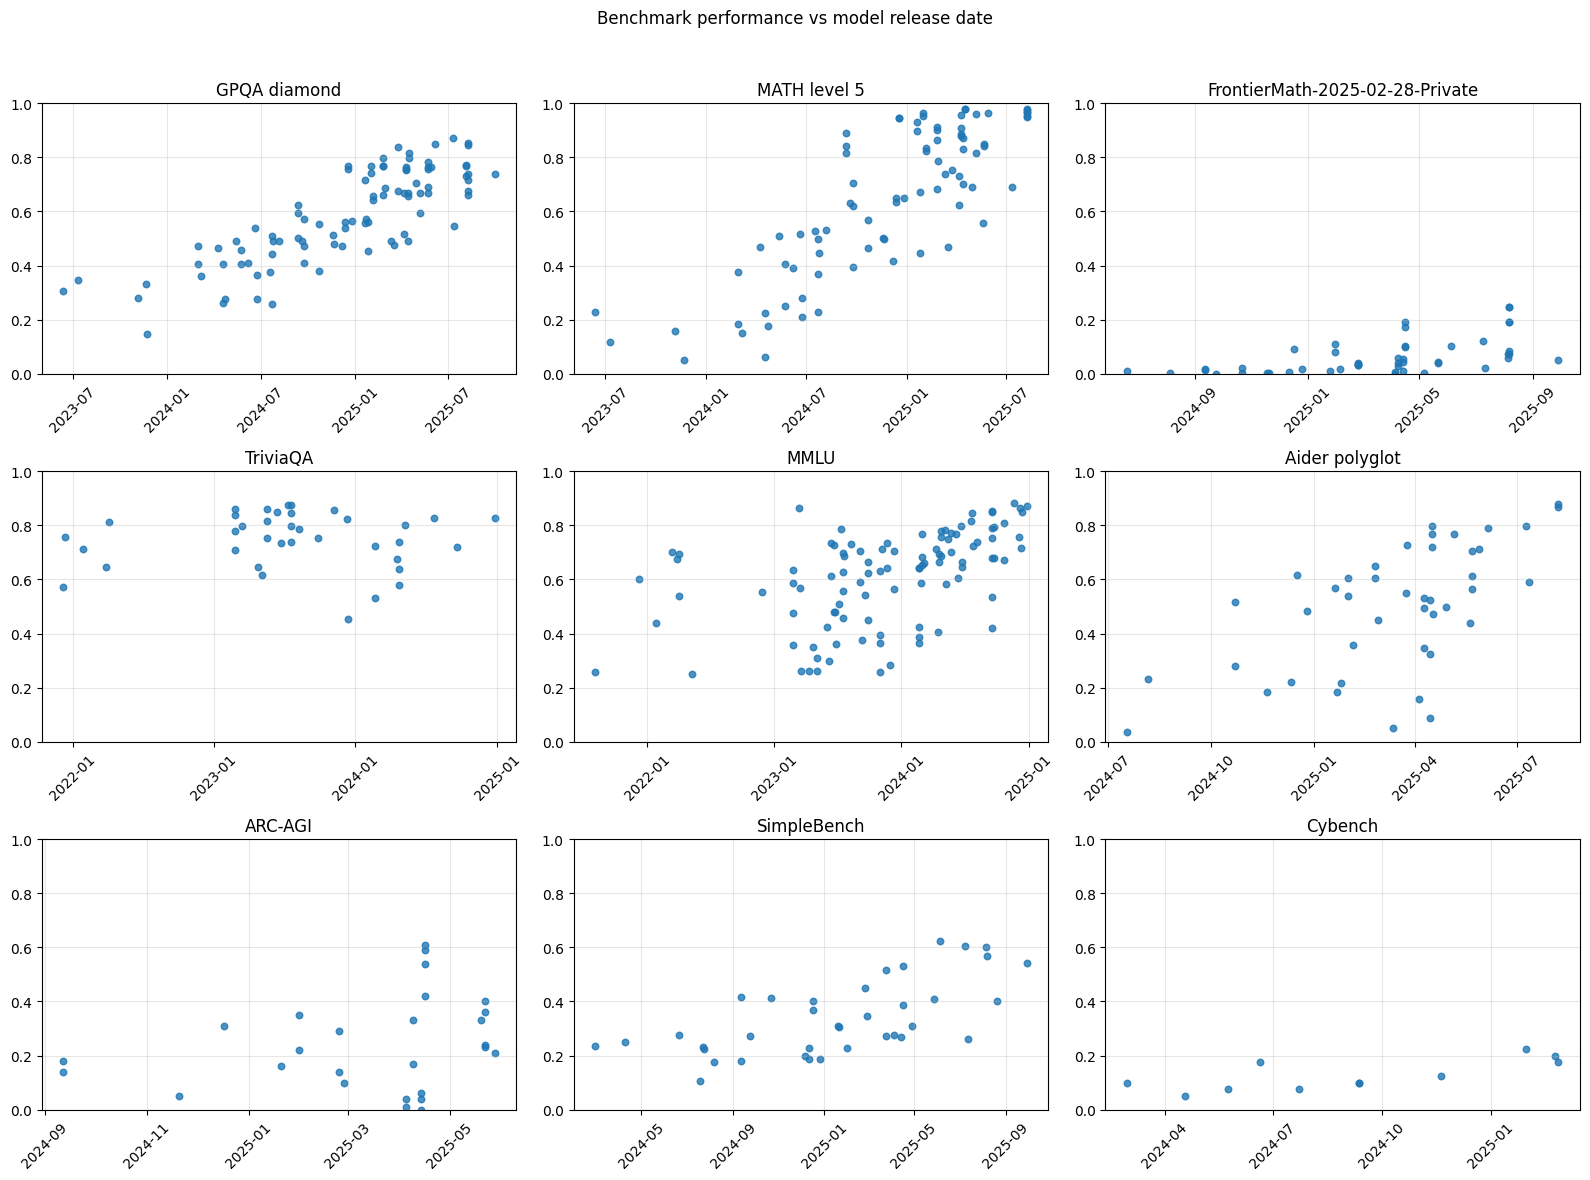

In [5]:
# 3x3 grid: Benchmark performance vs time for selected benchmarks (or random if none specified)
import numpy as np

# Prepare data
_df = scores_df.copy()
_df['date_parsed'] = pd.to_datetime(_df['date'], errors='coerce')

# Specify benchmarks to include (edit this list). If empty, a random selection will be used.
user_selected_benchmarks = [
    "GPQA diamond", "MATH level 5", "FrontierMath-2025-02-28-Private", 
    "TriviaQA", "MMLU", "Aider polyglot",
    "ARC-AGI", "SimpleBench", "Cybench"
]

rng = np.random.default_rng(0)
unique_benchmarks = _df['benchmark'].dropna().unique().tolist()

if len(user_selected_benchmarks) > 0:
    # Validate and keep only those present
    selected_clean = [b for b in user_selected_benchmarks if b in unique_benchmarks]
    missing = [b for b in user_selected_benchmarks if b not in unique_benchmarks]
    if missing:
        print(f"Warning: {len(missing)} benchmarks not found and will be skipped: {missing}")
    selected_benchmarks = np.array(selected_clean)
else:
    # Fallback to random nine
    num_to_draw = min(9, len(unique_benchmarks))
    selected_benchmarks = rng.choice(unique_benchmarks, size=num_to_draw, replace=False)

# Cap at 9 for a 3x3 grid
if len(selected_benchmarks) > 9:
    print(f"Note: More than 9 specified; showing the first 9: {selected_benchmarks[:9].tolist()}")
    selected_benchmarks = selected_benchmarks[:9]

num_to_plot = len(selected_benchmarks)

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(16, 12), sharey=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i >= num_to_plot:
        fig.delaxes(ax)
        continue
    bench = selected_benchmarks[i]
    sub = (
        _df[_df['benchmark'] == bench]
        .dropna(subset=['date_parsed', 'performance'])
        .sort_values('date_parsed')
    )
    ax.scatter(sub['date_parsed'], sub['performance'], s=22, alpha=0.8)
    ax.set_title(str(bench))
    ax.set_ylim(0, 1)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=3, maxticks=6))
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.grid(True, alpha=0.3)

    # Ensure tick labels show on all subplots (not just edge axes)
    ax.tick_params(labelbottom=True, labelleft=True)
    for lbl in ax.get_xticklabels():
        lbl.set_visible(True)
    for lbl in ax.get_yticklabels():
        lbl.set_visible(True)

fig.suptitle('Benchmark performance vs model release date')
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("outputs/notebooks/benchmark_performance_vs_time_grid.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [6]:
pd.read_csv("https://epoch.ai/data/all_ai_models.csv")["Notability criteria"]

0       SOTA improvement
1                    NaN
2                    NaN
3       SOTA improvement
4          Discretionary
              ...       
3187                 NaN
3188                 NaN
3189                 NaN
3190                 NaN
3191                 NaN
Name: Notability criteria, Length: 3192, dtype: object

In [7]:
# Fraction of models in scores_df that are notable per Epoch all_ai_models (using model name mapping)
import pandas as pd

# Map model IDs in scores_df to human-readable names using model_versions.csv
_mv = pd.read_csv("data/model_versions.csv")[["id", "Model"]].rename(columns={"id": "model"})
_unique_ids = scores_df[["model"]].drop_duplicates()
_unique_with_names = _unique_ids.merge(_mv, on="model", how="left")

# Use the mapped name when available; fall back to the ID string
_unique_with_names["model_name"] = _unique_with_names["Model"].fillna(_unique_with_names["model"].astype(str))
_unique_with_names["model_norm"] = _unique_with_names["model_name"].astype(str).str.lower().str.strip()

# Load Epoch's all_ai_models.csv and normalize
_df_all = pd.read_csv("https://epoch.ai/data/all_ai_models.csv")
_name_candidates = [
    "Model", "Name", "Model name", "Model Name", "model", "name", "model_name"
]
_name_col = next((c for c in _name_candidates if c in _df_all.columns), None)

if _name_col is None:
    print("Could not find a model name column in all_ai_models.csv; available columns:")
    print(list(_df_all.columns))
else:
    _df_all = _df_all.copy()
    _df_all["model_norm"] = _df_all[_name_col].astype(str).str.lower().str.strip()
    _df_all_norm = _df_all[["model_norm", "Notability criteria", _name_col]].drop_duplicates(subset=["model_norm"])

    # Merge normalized names to attach notability
    _merged = _unique_with_names.merge(_df_all_norm, on="model_norm", how="left")
    _merged["is_notable"] = _merged["Notability criteria"].notna()

    _total = len(_merged)
    _num_notable = int(_merged["is_notable"].sum())
    _frac_notable = _num_notable / _total if _total else float("nan")

    print(f"Unique model IDs in scores_df: {_total}")
    print(f"Models with non-NaN 'Notability criteria': {_num_notable}")
    print(f"Fraction notable: {_frac_notable:.3f}")

    # Diagnostics
    _num_missing_names = int(_unique_with_names["Model"].isna().sum())
    if _num_missing_names:
        print(f"Warning: {_num_missing_names} model IDs lacked a name in model_versions.csv (using ID as fallback).")

    _missing_examples = _merged.loc[~_merged["is_notable"], "model_name"].head(20).tolist()
    if _missing_examples:
        print("Examples without 'Notability criteria':", _missing_examples)



Unique model IDs in scores_df: 185
Models with non-NaN 'Notability criteria': 98
Fraction notable: 0.530
Examples without 'Notability criteria': ['Gemini 2.0 Flash', 'phi-3-small 7.4B', 'Phi-2', 'Mistral 7B', 'Gemma 7B', 'Gemma 2 27B', 'Yi 6B', 'Yi-9B', 'PaLM 2-S', 'PaLM 2-M', 'PaLM 2-L', 'Claude 3 Haiku', 'Falcon-7B', 'MPT-7B', 'chatglm2-6b', 'internlm-7b', 'internlm-20b', 'Baichuan 2-7B', 'Baichuan2-13B', 'LLaMA-33B']


In [8]:
# Setup environment and imports (mirrors analyze_data_exploration.py)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure project root cwd for relative paths
from analysis_utils import setup_analysis_environment, setup_plotting_style
setup_analysis_environment()
setup_plotting_style()

# Load prepared dataframes
from data_loader import scores_df

# Output directory (same as script)
output_dir = Path("outputs/data_exploration")
output_dir.mkdir(parents=True, exist_ok=True)

scores_df.head(3)


,model_id,benchmark_id,performance,benchmark,benchmark_release_date,optimized,is_math,is_coding,model,date,source
0,m1,b1,0.870,GPQA diamond,2023-11-20,True,False,False,grok-4-0709,2025-07-09,Epoch evaluations
1,m1,b11,0.436,Balrog,2024-11-20,False,False,False,grok-4-0709,2025-07-09,None
2,m1,b17,0.548,DeepResearch Bench,2025-06-13,False,False,False,grok-4-0709,2025-07-09,DeepResearchBench Leaderboard


In [9]:
# Dataset overview (generate_dataset_overview)

df = scores_df.copy()
df['date'] = pd.to_datetime(df['date'])

# Basic statistics
total_entries = len(df)
unique_models = df['model'].nunique()
unique_benchmarks = df['benchmark'].nunique()

# Date range
dates = pd.to_datetime(df['date'])
date_range = f"{dates.min().strftime('%Y-%m-%d')} to {dates.max().strftime('%Y-%m-%d')}"

# Performance statistics
perf_stats = df['performance'].describe()

# Optional breakdowns
source_counts = df['source'].value_counts() if 'source' in df.columns else None
optim_counts = df['optimized'].value_counts() if 'optimized' in df.columns else None

# Benchmark stats (top 15 by model coverage)
benchmark_stats = df.groupby('benchmark').agg({
    'model': 'nunique',
    'performance': ['mean', 'std', 'min', 'max']
}).round(4)
benchmark_stats.columns = ['num_models', 'mean_perf', 'std_perf', 'min_perf', 'max_perf']
benchmark_stats = benchmark_stats.sort_values('num_models', ascending=False)

# Persist to outputs (match script behavior)
overview_path = output_dir / "dataset_overview.txt"
with open(overview_path, 'w') as f:
    f.write("BENCHMARK STITCHING DATASET OVERVIEW\n")
    f.write("=" * 50 + "\n\n")
    f.write("BASIC STATISTICS:\n")
    f.write(f"  Total entries: {total_entries:,}\n")
    f.write(f"  Unique models: {unique_models}\n")
    f.write(f"  Unique benchmarks: {unique_benchmarks}\n")
    f.write(f"  Date range: {date_range}\n\n")

    f.write("PERFORMANCE STATISTICS:\n")
    for stat, value in perf_stats.items():
        f.write(f"  {stat}: {value:.4f}\n")
    f.write("\n")

    if source_counts is not None:
        f.write("SOURCE BREAKDOWN:\n")
        for source, count in source_counts.items():
            f.write(f"  {source}: {count} ({count/total_entries*100:.1f}%)\n")
        f.write("\n")

    if optim_counts is not None:
        f.write("OPTIMIZATION STATUS:\n")
        for status, count in optim_counts.items():
            f.write(f"  {'Optimized' if status else 'Not optimized'}: {count} ({count/total_entries*100:.1f}%)\n")
        f.write("\n")

    f.write("BENCHMARK STATISTICS (Top 15 by model count):\n")
    f.write(f"{'Benchmark':<30} {'Models':<8} {'Mean':<8} {'Std':<8} {'Min':<8} {'Max':<8}\n")
    f.write("-" * 80 + "\n")
    for benchmark, row in benchmark_stats.head(15).iterrows():
        f.write(f"{benchmark:<30} {row['num_models']:<8} {row['mean_perf']:<8.3f} "
                f"{row['std_perf']:<8.3f} {row['min_perf']:<8.3f} {row['max_perf']:<8.3f}\n")

# benchmark_stats.to_csv(output_dir / "benchmark_statistics.csv")

# print("Overview written to:", overview_path)
{
    'total_entries': total_entries,
    'unique_models': unique_models,
    'unique_benchmarks': unique_benchmarks,
    'date_range': date_range
}


{'total_entries': 1405,
 'unique_models': 185,
 'unique_benchmarks': 41,
 'date_range': '2019-11-05 to 2025-09-29'}

,year_month,count,date
0,2019-11,6,2019-11-01
1,2021-08,7,2021-08-01
2,2021-12,11,2021-12-01
3,2022-01,19,2022-01-01
4,2022-03,12,2022-03-01
5,2022-04,23,2022-04-01
6,2022-05,13,2022-05-01
7,2022-11,4,2022-11-01
8,2023-02,46,2023-02-01
9,2023-03,26,2023-03-01


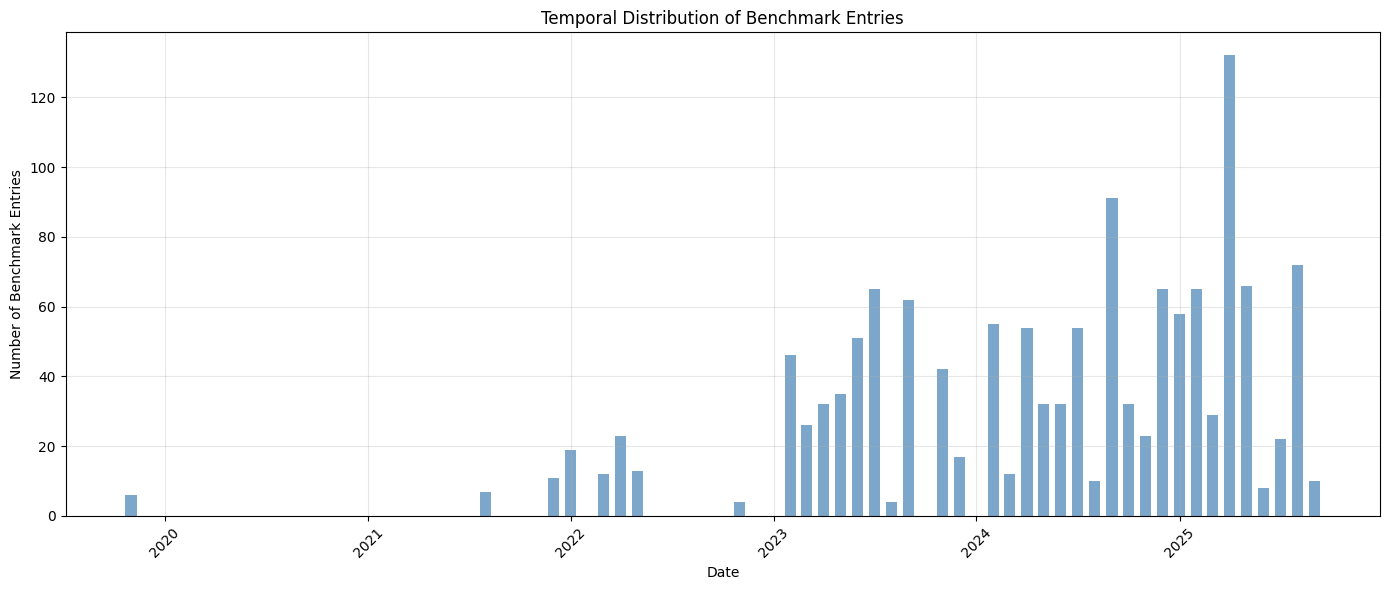

In [11]:
# Temporal distribution (analyze_temporal_distribution)

df = scores_df.copy()
df['date_obj'] = pd.to_datetime(df['date'])
df['year_month'] = df['date_obj'].dt.to_period('M')
monthly_counts = df.groupby('year_month').size().reset_index(name='count')
monthly_counts['date'] = monthly_counts['year_month'].dt.to_timestamp()

fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(monthly_counts['date'], monthly_counts['count'], width=20, alpha=0.7, color='steelblue')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Benchmark Entries')
ax.set_title('Temporal Distribution of Benchmark Entries')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(output_dir / "temporal_distribution.pdf", dpi=300, bbox_inches='tight')
monthly_counts.head(10)


{'most_covered_benchmark': ('GPQA diamond', 87),
 'most_evaluated_model': ('claude-3-5-sonnet-20241022', 16)}

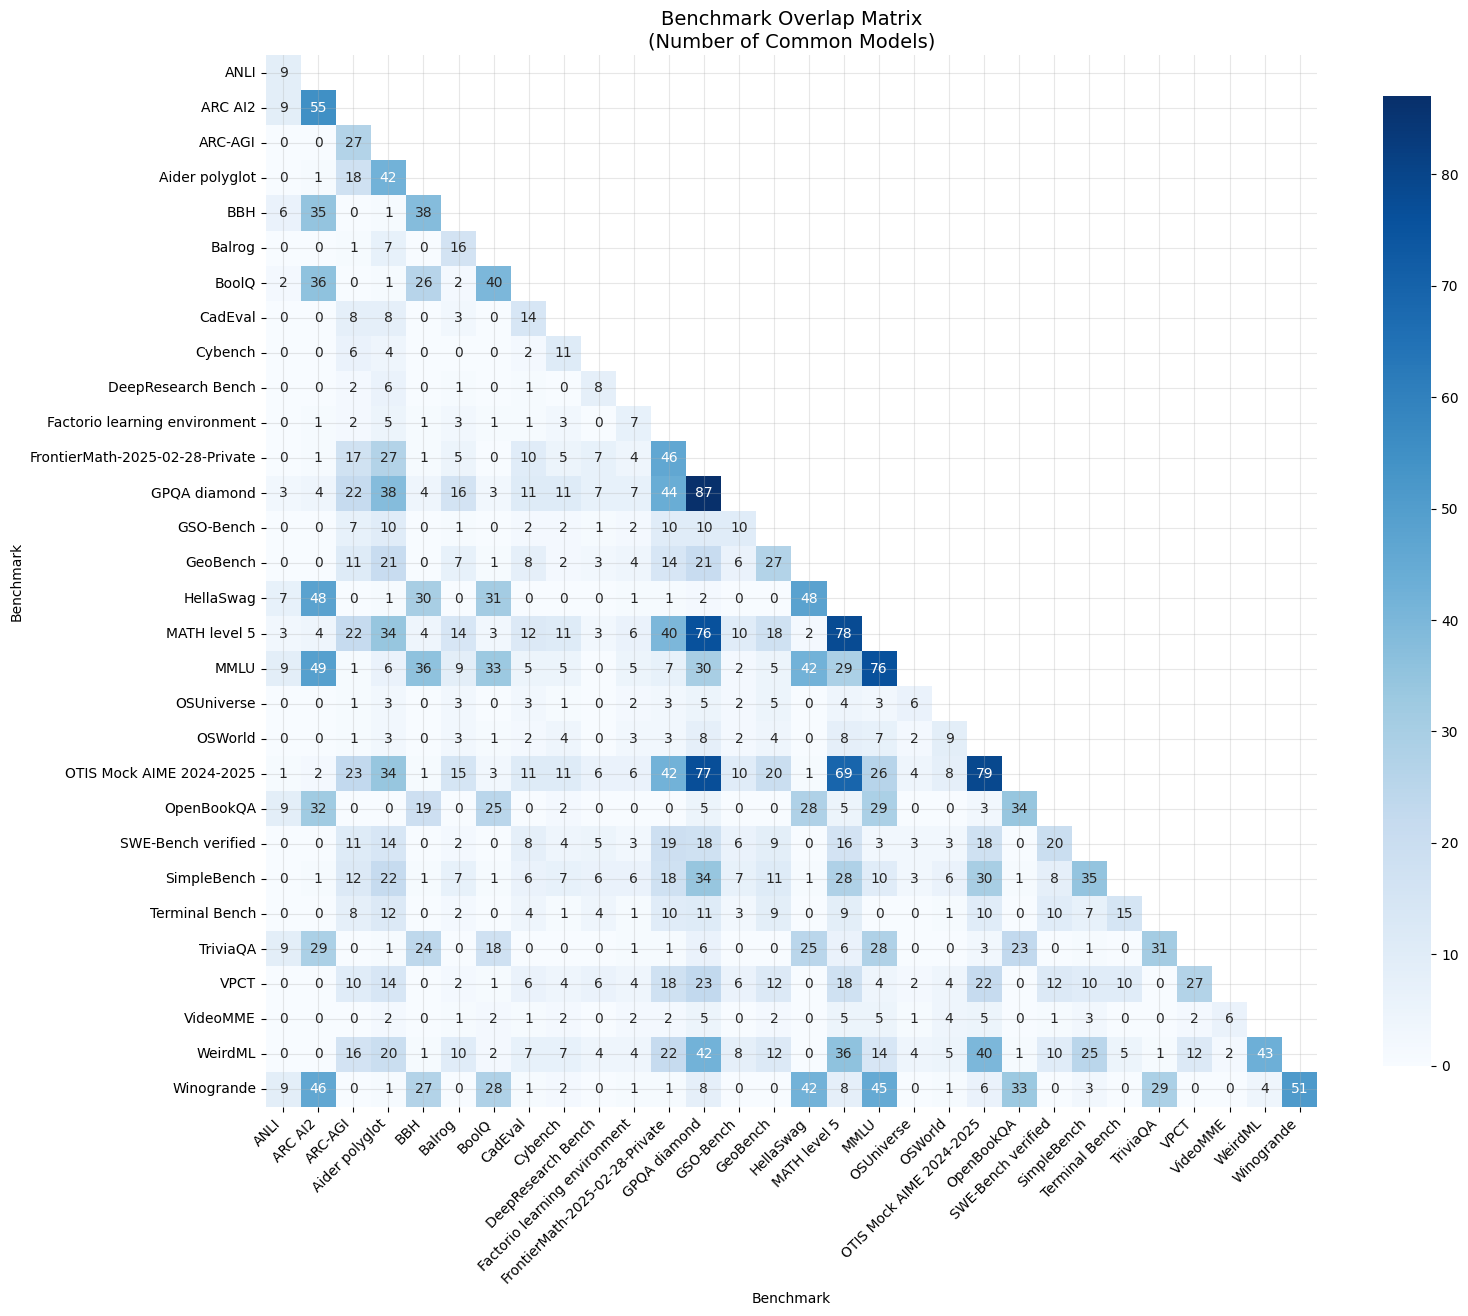

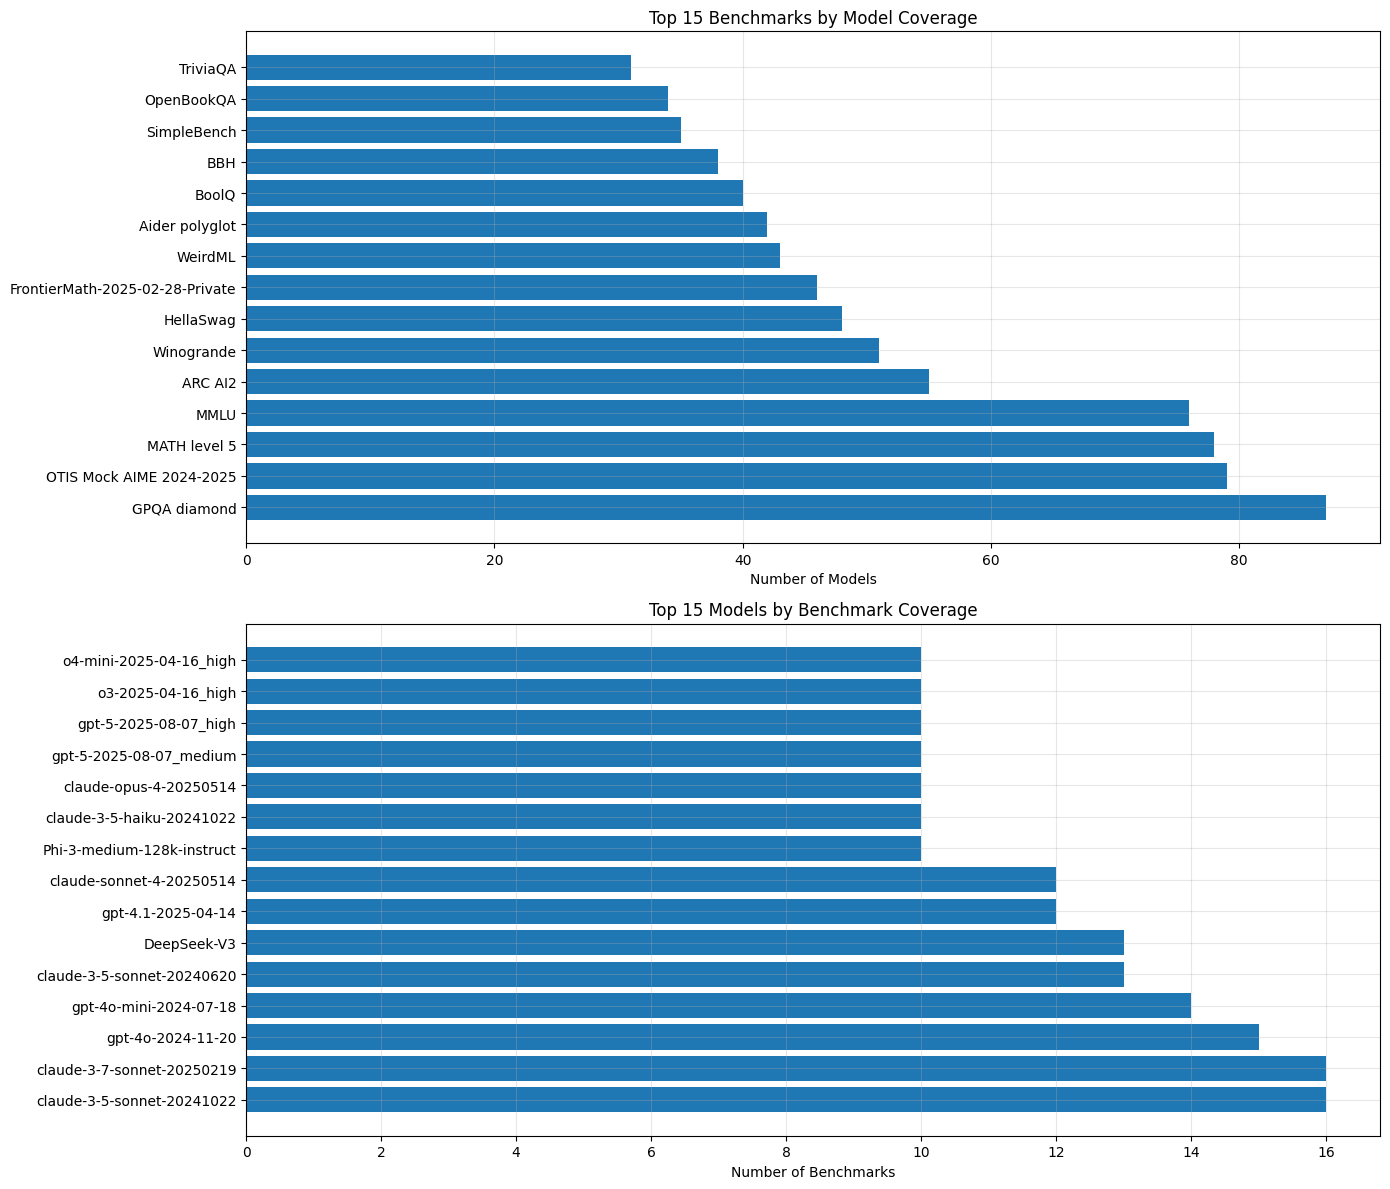

In [7]:
# Overlap matrix and coverage (create_overlap_matrix + analyze_benchmark_coverage)

# Model-benchmark matrix (count of records per model-benchmark)
model_benchmark_matrix = scores_df.pivot_table(
    index='model',
    columns='benchmark',
    values='performance',
    aggfunc='count',
    fill_value=0
)

# Binary presence matrix
model_benchmark_binary = (model_benchmark_matrix > 0).astype(int)

# Overlap matrix: common models between benchmark pairs
overlap_matrix = model_benchmark_binary.T @ model_benchmark_binary

# Heatmap (lower triangle)
fig, ax = plt.subplots(figsize=(16, 14))
mask = np.triu(np.ones_like(overlap_matrix), k=1)
sns.heatmap(
    overlap_matrix,
    mask=mask,
    annot=True,
    fmt='d',
    cmap='Blues',
    square=True,
    ax=ax,
    cbar_kws={"shrink": .8}
)
ax.set_title('Benchmark Overlap Matrix\n(Number of Common Models)', fontsize=14)
ax.set_xlabel('Benchmark')
ax.set_ylabel('Benchmark')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(output_dir / "benchmark_overlap_matrix.png", dpi=300, bbox_inches='tight')

# Coverage stats
models_per_benchmark = model_benchmark_binary.sum(axis=0).sort_values(ascending=False)
benchmarks_per_model = model_benchmark_binary.sum(axis=1).sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
# Top benchmarks by model count
top_benchmarks = models_per_benchmark.head(15)
ax1.barh(range(len(top_benchmarks)), top_benchmarks.values)
ax1.set_yticks(range(len(top_benchmarks)))
ax1.set_yticklabels(top_benchmarks.index)
ax1.set_xlabel('Number of Models')
ax1.set_title('Top 15 Benchmarks by Model Coverage')
ax1.grid(True, alpha=0.3, axis='x')

# Top models by benchmark count
top_models = benchmarks_per_model.head(15)
ax2.barh(range(len(top_models)), top_models.values)
ax2.set_yticks(range(len(top_models)))
ax2.set_yticklabels(top_models.index)
ax2.set_xlabel('Number of Benchmarks')
ax2.set_title('Top 15 Models by Benchmark Coverage')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(output_dir / "benchmark_coverage_analysis.png", dpi=300, bbox_inches='tight')

{
    'most_covered_benchmark': (models_per_benchmark.index[0], int(models_per_benchmark.iloc[0])) if len(models_per_benchmark) else None,
    'most_evaluated_model': (benchmarks_per_model.index[0], int(benchmarks_per_model.iloc[0])) if len(benchmarks_per_model) else None
}
